In [116]:
import pandas as pd  # Used for data manipulation and analysis.
import numpy as np   # Used for numerical operations and efficient array manipulations.
import random        # Required for generating random numbers, Used for initializing medoids randomly.
import itertools     # Used for creating iterators for efficient.
import matplotlib.pyplot as plt  # Used for creating visualizations and plots of the data.

In [117]:
#Dataset Link: https://www.kaggle.com/datasets/yashgpt/us-college-data
df = pd.read_csv("College_Data.csv") # Load data from CSV into DataFrame
df.head() # Preview the initial rows of the DataFrame

,University Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc
0,Abilene Christian University,Yes,1660,1232,721,23,52
1,Adelphi University,Yes,2186,1924,512,16,29
2,Adrian College,Yes,1428,1097,336,22,50
3,Agnes Scott College,Yes,417,349,137,60,89
4,Alaska Pacific University,Yes,193,146,55,16,44


In [118]:
# Drop the first two columns from the DataFrame and display.
df1 = df.drop(df.columns[[0,1]], axis =1)
df1.head()

,Apps,Accept,Enroll,Top10perc,Top25perc
0,1660,1232,721,23,52
1,2186,1924,512,16,29
2,1428,1097,336,22,50
3,417,349,137,60,89
4,193,146,55,16,44


In [119]:
#check if there is any empty value in a raw.
df.isnull().sum()

University Name    0
Private            0
Apps               0
Accept             0
Enroll             0
Top10perc          0
Top25perc          0
dtype: int64

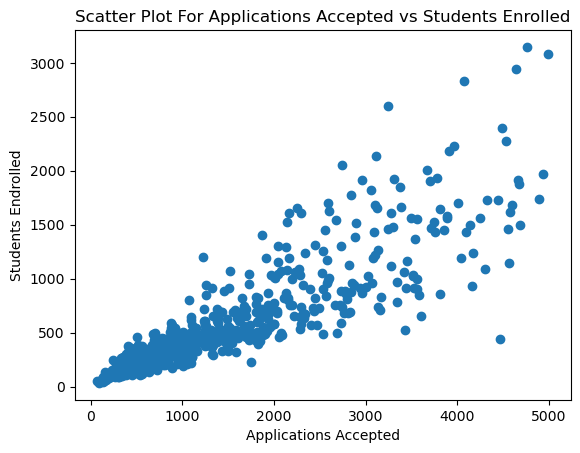

In [120]:
# Extract two columns of interest from the dataframe to visualize
x = df1.iloc[:, 1].tolist()
y = df1.iloc[:, 2].tolist()

# Create the plot
plt.scatter(x, y)

# Add labels and title
plt.xlabel('Applications Accepted')
plt.ylabel('Students Endrolled')
plt.title('Scatter Plot For Applications Accepted vs Students Enrolled')

# Show the plot
plt.show()

In [121]:
# Converts DataFrame to NumPy array for efficient computations.
data = df1.to_numpy()

In [122]:
# Calculates and returns the Euclidean distance between two points p1 and p2.
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

# Assigns each point to the cluster with the closest medoid, and returns the distances, cost, and assignments.
def cluster_assignment(data, medoids, previous_distance, cluster_count):
    if previous_distance is None:
        distances = np.zeros((data.shape[0], cluster_count))
    else:
        distances = previous_distance.copy()

    for i in range(cluster_count):
        distances[:, i] = np.sum((data - data[medoids[i], :])**2, axis=1)

    cost = np.amin(distances, axis=1).sum()
    assignments = np.argmin(distances, axis=1)
    return distances, cost, assignments

In [123]:
# The clarans function takes in a data set "data", the number of clusters "cluster_count", the number of neighbors to explore "max_neighbors" and the number of local minima to explore "num_local".
def clarans(data, cluster_count, max_neighbors, num_local):
    
    # Initialize variables to store the best clustering solution
    best_medoids, best_assignments, best_distances, best_cost = None, None, None, None

    for local_iteration in range(num_local):
        # Randomly initialize a set of medoids.
        current_medoids = np.random.choice(data.shape[0], cluster_count, replace=False)
        distances, cost, assignments = cluster_assignment(data, current_medoids, None, cluster_count)

        neighbor_iteration = 1
        while neighbor_iteration <= max_neighbors:
            # Generate a random neighbor by swapping a medoid with a non-medoid point.
            random_neighbor_index = random.choice(range(cluster_count))
            random_neighbor = random.choice(list(set(range(data.shape[0])) - set(current_medoids)))
            
            # Create a new set of medoids by replacing the selected medoid with the random_neighbor.
            new_medoids = current_medoids.copy()
            new_medoids[random_neighbor_index] = random_neighbor

            # Evaluate the cost of the new set of medoids.
            new_distance, new_cost, new_assign = cluster_assignment(data, new_medoids, distances, cluster_count)

            # If the new set of medoids has a lower cost, update the current solution and reset the neighbor search.
            if new_cost < cost:
                current_medoids, assignments, distances, cost = new_medoids, new_assign, new_distance, new_cost
                neighbor_iteration = 1
            else:
                neighbor_iteration += 1

        # Compares the cost of the current solution with the best clustering solution found so far.
        if best_cost is None or cost < best_cost:
            best_medoids, best_assignments, best_distances, best_cost = current_medoids.copy(), assignments, distances, cost

    return best_medoids, best_assignments, best_distances, best_cost

In [124]:
#The run_clarans_with_hyperparameters function executes the CLARANS algorithm on a given dataset with specified hyperparameters.
def run_clarans_with_hyperparameters(data, cluster, max_neighbors, num_local):
    best_medoids, best_assignments, best_distances, best_cost = clarans(data, cluster, max_neighbors, num_local)
    return best_cost # Return the cost of the best clustering found by CLARANS

# Define hyperparameter search space.
Cluster_values = [3, 4, 5, 6]
num_local_values = [50, 100, 150, 200]
max_neighbors_values = [5, 10, 15, 20]

# Initialize variables to store the best hyperparameters and their corresponding performance.
best_hyperparameters = None
best_performance = float('inf')

# Perform grid search to find the best hyperparameter combination.
for cluster_val, num_local_val, max_neighbors_val in itertools.product(Cluster_values, num_local_values, max_neighbors_values):
    # Run CLARANS algorithm with current hyperparameters
    cost = run_clarans_with_hyperparameters(data, cluster_val, max_neighbors_val, num_local_val)

    # Update best hyperparameters if the current combination performs better.
    if cost < best_performance:
        best_hyperparameters = (cluster_val, num_local_val, max_neighbors_val)
        best_performance = cost


# Run CLARANS algorithm with the best hyperparameters.
best_medoids, best_assignments, best_distances, best_cost = clarans(data, best_hyperparameters[0], best_hyperparameters[2], best_hyperparameters[1])


# Print the best hyperparameters and their corresponding performance.
print("Best Hyperparameters:", best_hyperparameters)
print("Best Cost in a iteration:", best_performance) #the Best performance of a set of medoids in a particular iteration.

Best Hyperparameters: (6, 100, 20)
Best Cost in a iteration: 321366573.0


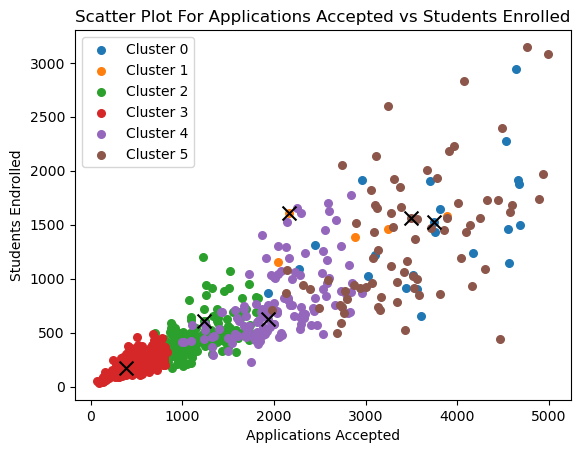

In [125]:
# Iterate through each cluster and visualize its points.
for cluster_index in range(int(best_hyperparameters[0])):
    cluster = data[best_assignments == cluster_index]
    plt.scatter(cluster[:, 1], cluster[:, 2], s=30, label=f'Cluster {cluster_index}')

# Iterate through medoids and visualize them as x markers.
for medoid_index in range(int(best_hyperparameters[0])):
    plt.scatter(data[best_medoids[medoid_index], 1], data[best_medoids[medoid_index], 2], marker='x', s=100, color='black')

# Add labels and title to the plot.
plt.xlabel('Applications Accepted')
plt.ylabel('Students Endrolled')
plt.title('Scatter Plot For Applications Accepted vs Students Enrolled')
plt.legend() # Show the legend for cluster labels.
plt.show() # Display the plot.

In [126]:
# indexes of best medoids 
best_medoids

array([414, 238, 614, 275, 492, 640])

In [127]:
# indexes of different clusters formed by algorithm
best_assignments

array([2, 4, 2, 3, 3, 3, 3, 2, 2, 3, 2, 4, 2, 2, 3, 2, 4, 2, 2, 4, 3, 0,
       3, 3, 2, 4, 3, 2, 3, 3, 3, 3, 2, 3, 2, 4, 3, 2, 3, 3, 2, 2, 2, 3,
       3, 4, 2, 3, 3, 3, 2, 3, 3, 0, 3, 3, 4, 3, 5, 5, 3, 2, 3, 3, 1, 2,
       5, 3, 4, 3, 3, 3, 0, 5, 2, 2, 3, 4, 2, 3, 4, 2, 2, 2, 5, 2, 2, 2,
       5, 3, 2, 3, 3, 3, 2, 4, 5, 4, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 4, 3,
       4, 3, 3, 3, 4, 5, 2, 5, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 0, 4,
       4, 3, 3, 0, 3, 3, 3, 3, 4, 3, 2, 4, 2, 2, 3, 3, 3, 0, 2, 3, 2, 4,
       2, 4, 3, 2, 3, 3, 3, 2, 4, 2, 3, 1, 2, 4, 3, 3, 2, 5, 3, 3, 2, 4,
       2, 3, 4, 4, 3, 0, 2, 3, 3, 2, 5, 2, 2, 2, 2, 4, 2, 3, 5, 4, 2, 3,
       3, 5, 3, 3, 4, 4, 2, 3, 3, 5, 3, 1, 0, 4, 3, 4, 3, 2, 3, 3, 2, 3,
       3, 5, 3, 3, 3, 2, 4, 2, 2, 3, 4, 2, 3, 0, 2, 3, 2, 2, 1, 2, 3, 3,
       3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 2, 5, 3, 5, 3, 4,
       3, 4, 0, 3, 3, 2, 5, 3, 4, 3, 4, 3, 2, 3, 2, 3, 4, 4, 3, 3, 3, 4,
       3, 2, 2, 2, 2, 5, 3, 3, 3, 4, 2, 3, 2, 3, 2,

In [128]:
best_distances

array([[5.04896610e+07, 1.50622532e+08, 8.10790000e+04, 2.46126100e+06,
        2.19150700e+06, 1.67558240e+07],
       [4.12013980e+07, 1.37664475e+08, 1.09416000e+06, 5.47095000e+06,
        6.15730000e+05, 1.12993430e+07],
       [5.50672140e+07, 1.57439617e+08, 9.36540000e+04, 1.47418200e+06,
        3.13290600e+06, 1.97716270e+07],
       ...,
       [4.19845250e+07, 1.39382902e+08, 9.50797000e+05, 5.30199300e+06,
        7.51423000e+05, 1.14775760e+07],
       [7.72604000e+06, 1.01520910e+07, 8.85566060e+07, 1.10549530e+08,
        6.07217000e+07, 3.41318450e+07],
       [3.20230050e+07, 1.19225914e+08, 2.90976100e+06, 8.83147300e+06,
        1.07230000e+04, 7.36064000e+06]])

In [129]:
#the best cost observed across multiple iterations and different sets of initial medoids.
best_cost

337643399.0